# Homework 03: Learning Curves and Training Workflow

## Due: Midnight on September 21 (with 2-hour grace period)

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

Throughout, you will use **early stopping** to select the model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [5]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This datasest is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [6]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [7]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [8]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [9]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Baseline Model - ReLU Activation



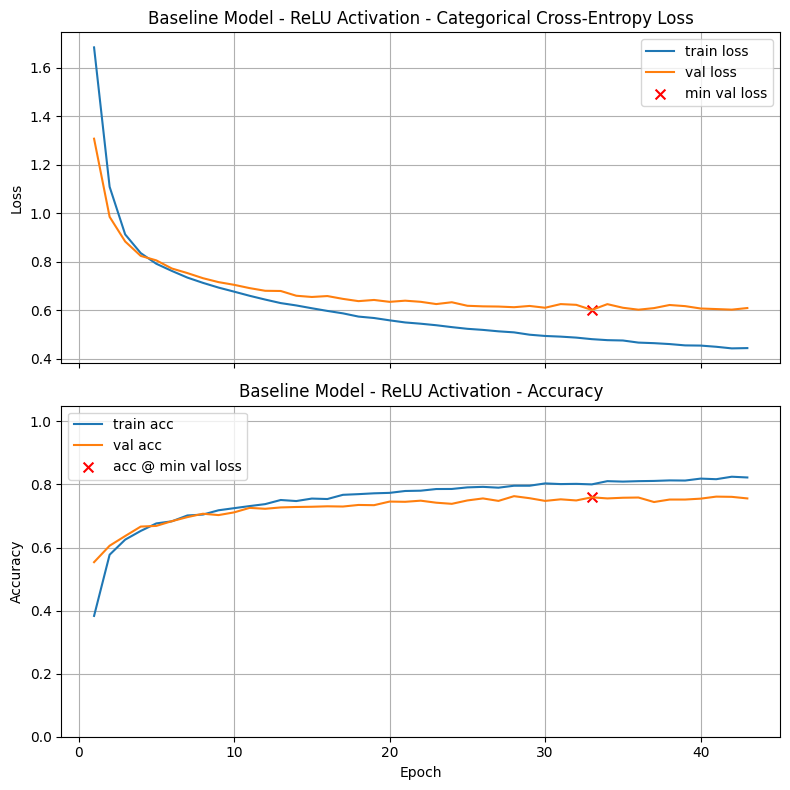

Final Training Loss:            0.4446
Final Training Accuracy:        0.8221
Final Validation Loss:          0.6099
Final Validation Accuracy:      0.7557
Minimum Validation Loss:        0.6021 (Epoch 33)
Validation Accuracy @ Min Loss: 0.7593

Test Loss: 0.6106
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:00:13


In [11]:
# Your code here. Add as many cells as you need. 

# relu activation
model_baseline_relu = build_model(X_train.shape[1], [ (64, 'relu', 0.0, 0.0), (32, 'relu', 0.0, 0.0)], n_classes)
train_and_test(model_baseline_relu, title="Baseline Model - ReLU Activation")


Baseline Model - Sigmoid Activation



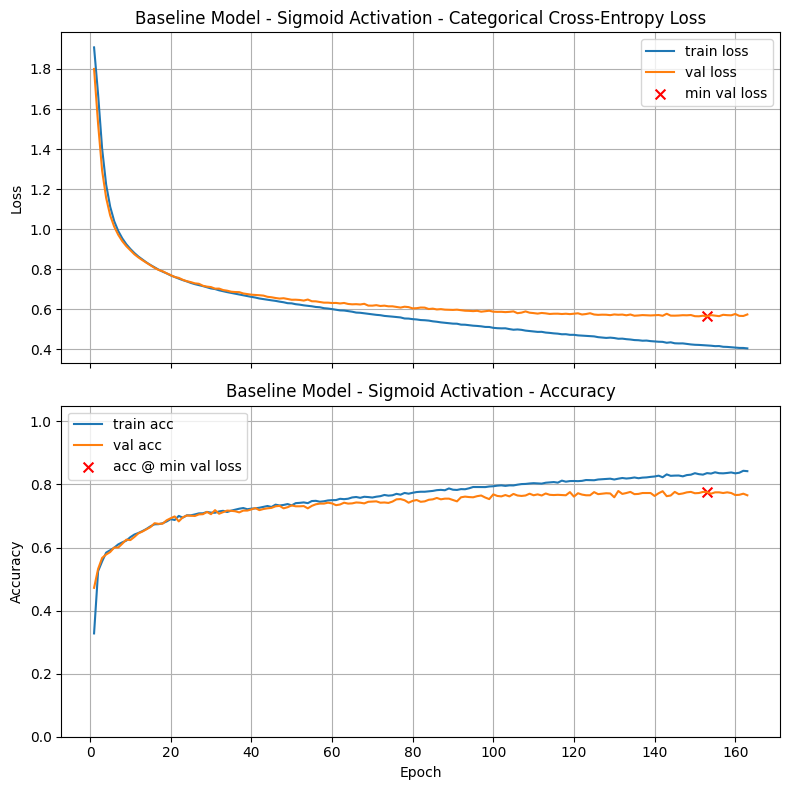

Final Training Loss:            0.4055
Final Training Accuracy:        0.8421
Final Validation Loss:          0.5748
Final Validation Accuracy:      0.7657
Minimum Validation Loss:        0.5652 (Epoch 153)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.5690
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:42


In [12]:
# sigmoid activation

model_baseline_sigmoid = build_model(X_train.shape[1], [ (64, 'sigmoid', 0.0, 0.0), (32, 'sigmoid', 0.0, 0.0)], n_classes)
train_and_test(model_baseline_sigmoid, title="Baseline Model - Sigmoid Activation")


Baseline Model - Tanh Activation



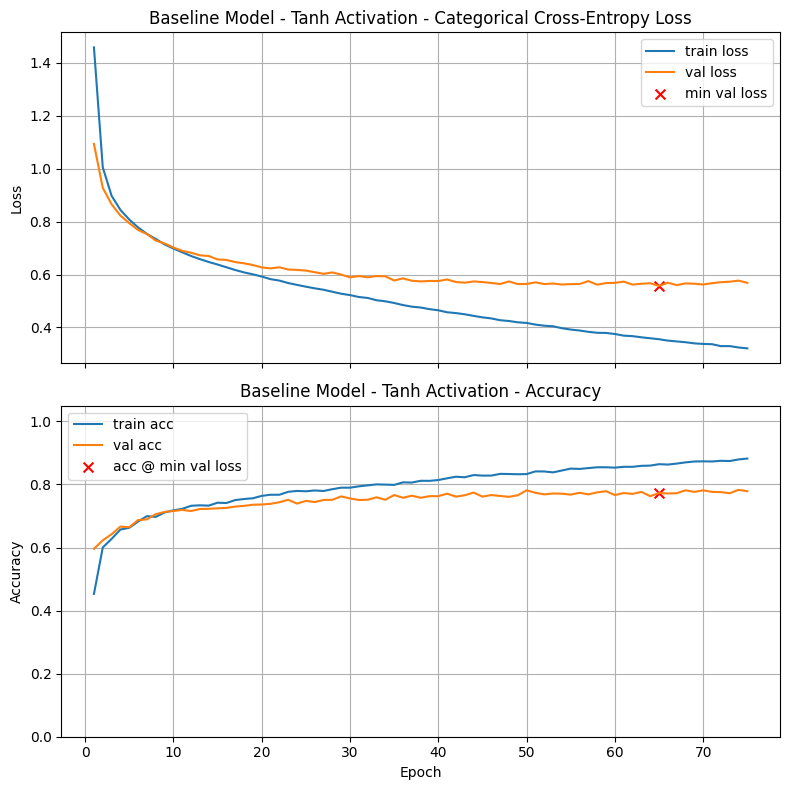

Final Training Loss:            0.3207
Final Training Accuracy:        0.8821
Final Validation Loss:          0.5685
Final Validation Accuracy:      0.7786
Minimum Validation Loss:        0.5568 (Epoch 65)
Validation Accuracy @ Min Loss: 0.7729

Test Loss: 0.5580
Test Accuracy: 0.7721

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:00:21


In [13]:
# tanh activation

model_baseline_tanh = build_model(X_train.shape[1], [ (64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.0)], n_classes)
train_and_test(model_baseline_tanh, title="Baseline Model - Tanh Activation")

### Graded Questions

In [14]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 1             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [15]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 1


In [16]:
# Set a1b to the validation accuracy found by this best activation function

a1b = 0.7757             # Replace 0.0 with your answer

In [17]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7757


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



Baseline Model - LR=1e-3



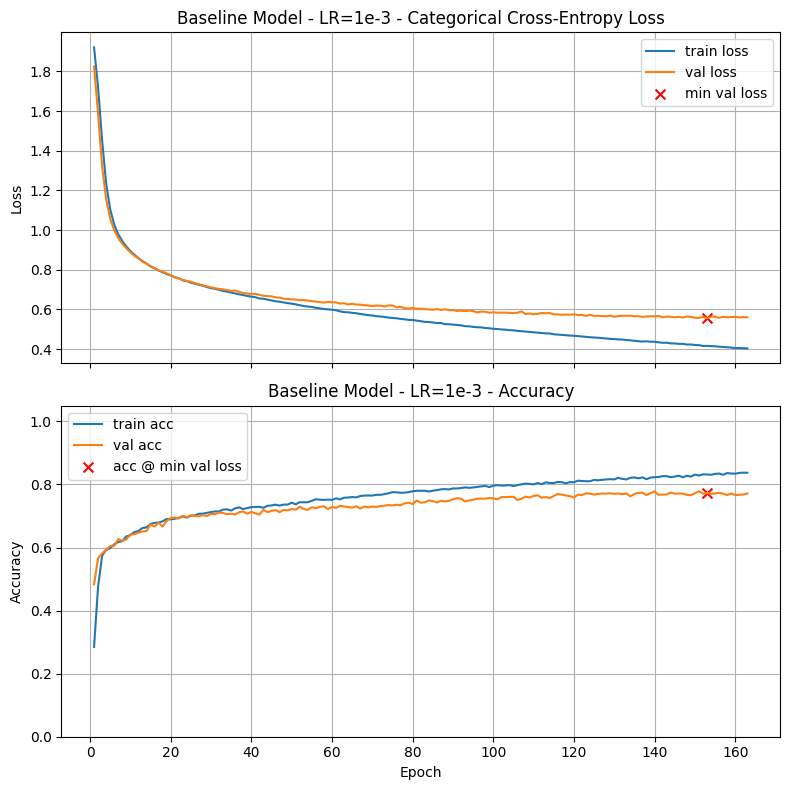

Final Training Loss:            0.4039
Final Training Accuracy:        0.8371
Final Validation Loss:          0.5603
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.5560 (Epoch 153)
Validation Accuracy @ Min Loss: 0.7729

Test Loss: 0.5799
Test Accuracy: 0.7600

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:43


In [30]:
# Your code here. Add as many cells as you need. 

lr_model_1 = build_model(X_train.shape[1], [ (64,'sigmoid',0.0,0.0), (32,'sigmoid',0.0,0.0)], n_classes)
train_and_test(lr_model_1, lr_schedule=1e-3, title=f"Baseline Model - LR=1e-3", return_history=False)


Baseline Model - LR=5e-4



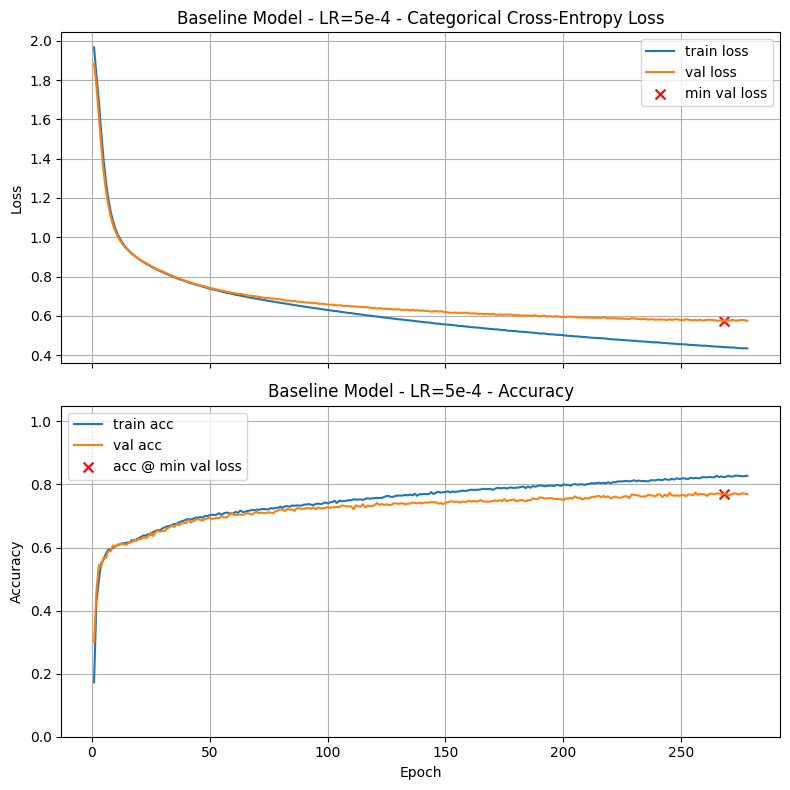

Final Training Loss:            0.4344
Final Training Accuracy:        0.8276
Final Validation Loss:          0.5746
Final Validation Accuracy:      0.7693
Minimum Validation Loss:        0.5743 (Epoch 268)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.5979
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.017143

Execution Time: 00:01:31


In [31]:
lr_model_2 = build_model(X_train.shape[1], [ (64,'sigmoid',0.0,0.0), (32,'sigmoid',0.0,0.0)], n_classes)
train_and_test(lr_model_2, lr_schedule=5e-4, title=f"Baseline Model - LR=5e-4", return_history=False)


Baseline Model - LR=1e-4



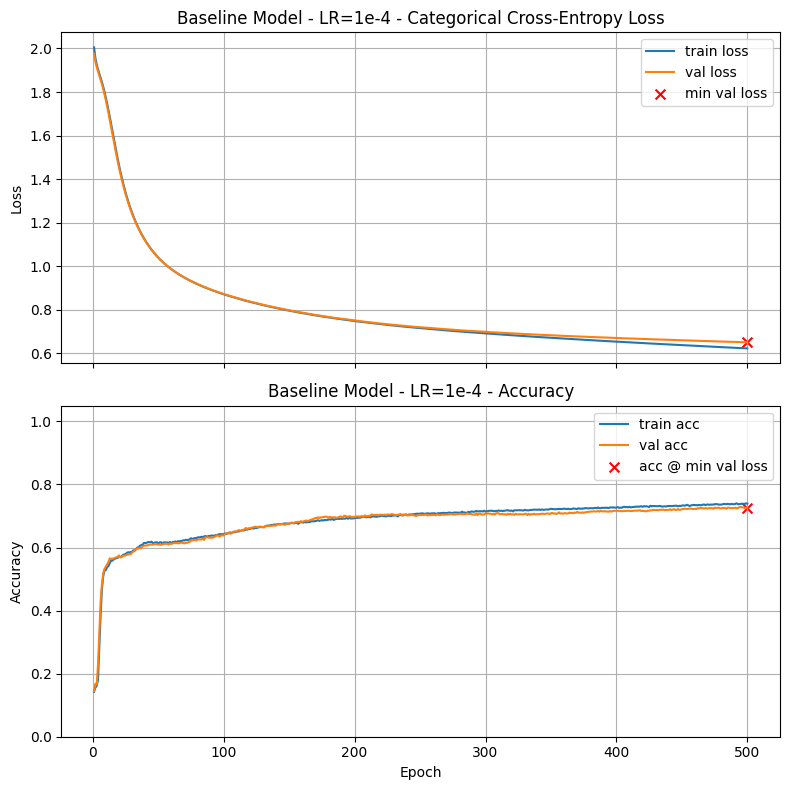

Final Training Loss:            0.6228
Final Training Accuracy:        0.7390
Final Validation Loss:          0.6506
Final Validation Accuracy:      0.7257
Minimum Validation Loss:        0.6506 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7257

Test Loss: 0.6734
Test Accuracy: 0.7150

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:02:54


In [32]:
lr_model_3 = build_model(X_train.shape[1], [ (64,'sigmoid',0.0,0.0), (32,'sigmoid',0.0,0.0)], n_classes)
train_and_test(lr_model_3, lr_schedule=1e-4, title=f"Baseline Model - LR=1e-4", return_history=False)


Baseline Model - LR=5e-5



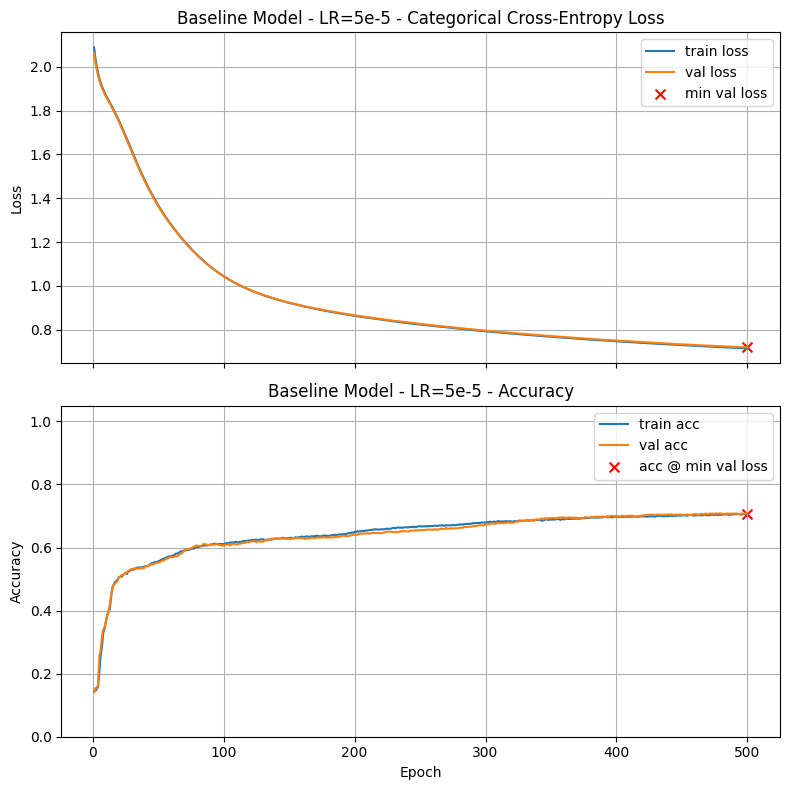

Final Training Loss:            0.7148
Final Training Accuracy:        0.7055
Final Validation Loss:          0.7192
Final Validation Accuracy:      0.7079
Minimum Validation Loss:        0.7192 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7079

Test Loss: 0.7441
Test Accuracy: 0.6979

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:03:00


In [33]:
lr_model_4 = build_model(X_train.shape[1], [ (64,'sigmoid',0.0,0.0), (32,'sigmoid',0.0,0.0)], n_classes)
train_and_test(lr_model_4, lr_schedule=5e-5, title=f"Baseline Model - LR=5e-5", return_history=False)


Baseline Model - LR=1e-5



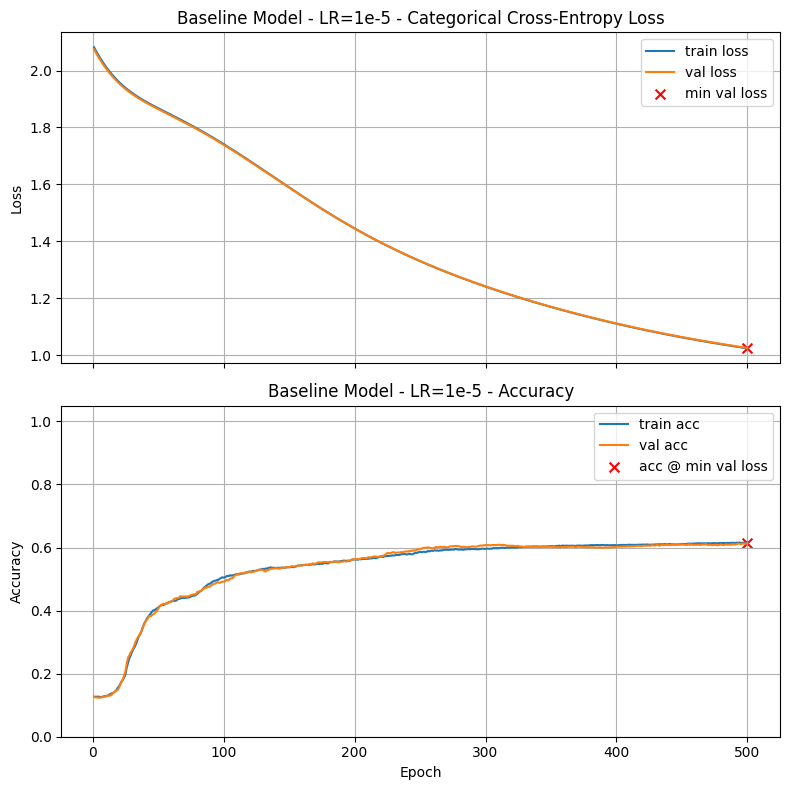

Final Training Loss:            1.0239
Final Training Accuracy:        0.6157
Final Validation Loss:          1.0254
Final Validation Accuracy:      0.6136
Minimum Validation Loss:        1.0254 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6136

Test Loss: 1.0253
Test Accuracy: 0.6186

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:03:40


In [34]:
lr_model_5 = build_model(X_train.shape[1], [ (64,'sigmoid',0.0,0.0), (32,'sigmoid',0.0,0.0)], n_classes)
train_and_test(lr_model_5, lr_schedule=1e-5, title=f"Baseline Model - LR=1e-5", return_history=False)

#### Graded Questions

In [35]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 1e-3           # Replace 0.0 with your answer

In [36]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.001000


In [37]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = 0.7729             # Replace 0.0 with your answer

In [38]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7729


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful hueristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Dropout Model 1



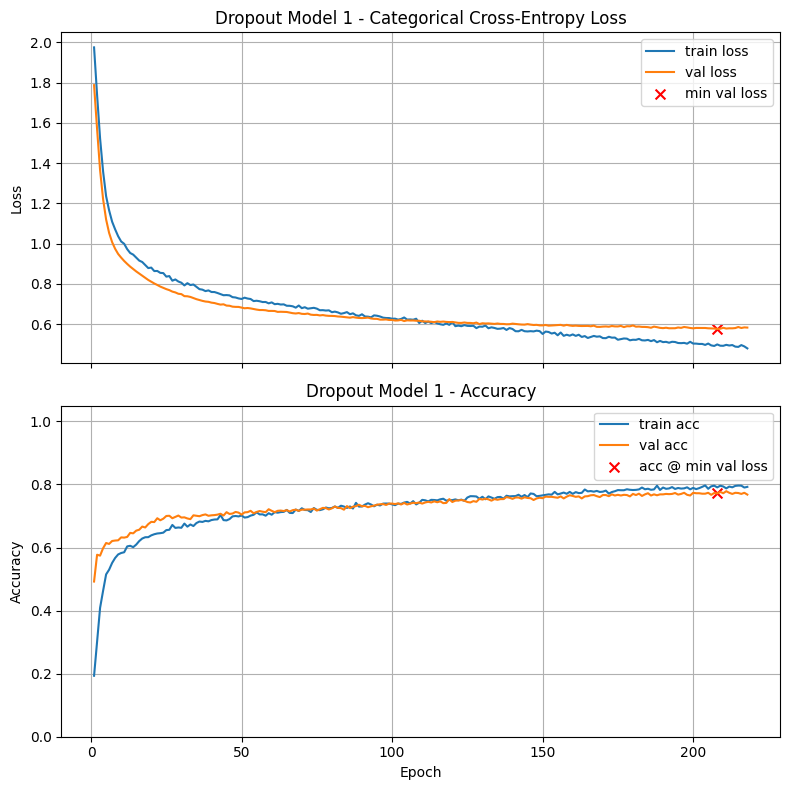

Final Training Loss:            0.4790
Final Training Accuracy:        0.7924
Final Validation Loss:          0.5823
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.5756 (Epoch 208)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6018
Test Accuracy: 0.7443

Validation-Test Gap (accuracy): 0.027143

Execution Time: 00:01:25


In [39]:
# Your code here. Add as many cells as you need. 

dropout_model_1 = build_model(X_train.shape[1], [ (64, 'sigmoid', 0.0, 0.0), (32, 'sigmoid', 0.0, 0.3)], n_classes)
train_and_test(dropout_model_1, lr_schedule=1e-3, title="Dropout Model 1", return_history=False)


Dropout Model 2



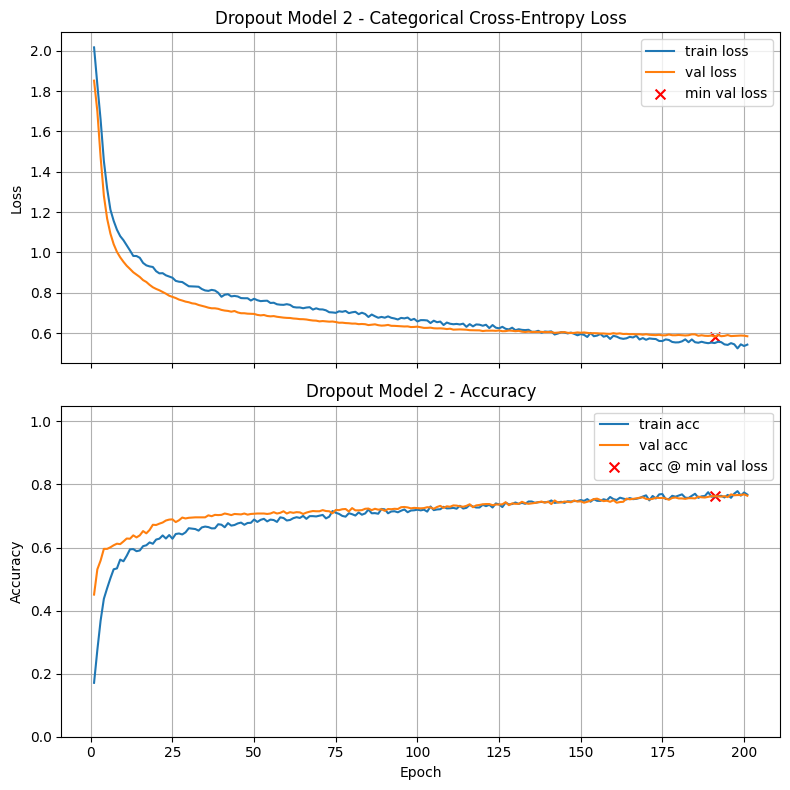

Final Training Loss:            0.5426
Final Training Accuracy:        0.7679
Final Validation Loss:          0.5842
Final Validation Accuracy:      0.7643
Minimum Validation Loss:        0.5820 (Epoch 191)
Validation Accuracy @ Min Loss: 0.7629

Test Loss: 0.6028
Test Accuracy: 0.7471

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:01:43


In [40]:
dropout_model_2 = build_model(X_train.shape[1], [ (64, 'sigmoid', 0.0, 0.0), (32, 'sigmoid', 0.0, 0.4)], n_classes)
train_and_test(dropout_model_2, lr_schedule=1e-3, title="Dropout Model 2", return_history=False)


Dropout Model 3



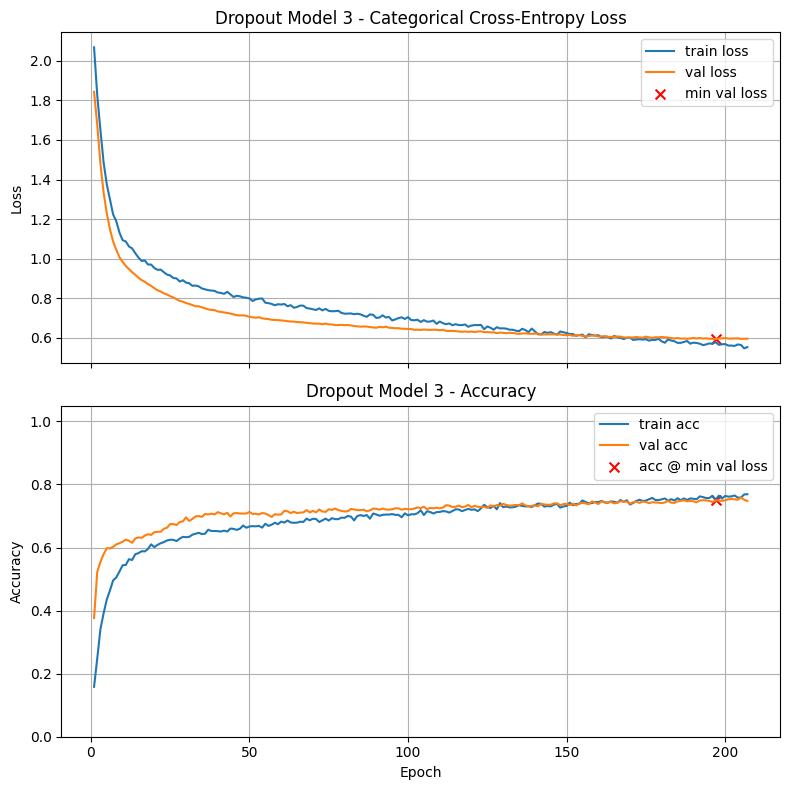

Final Training Loss:            0.5533
Final Training Accuracy:        0.7690
Final Validation Loss:          0.5951
Final Validation Accuracy:      0.7479
Minimum Validation Loss:        0.5931 (Epoch 197)
Validation Accuracy @ Min Loss: 0.7493

Test Loss: 0.6237
Test Accuracy: 0.7286

Validation-Test Gap (accuracy): 0.020714

Execution Time: 00:01:10


In [41]:
dropout_model_3 = build_model(X_train.shape[1], [ (64, 'sigmoid', 0.0, 0.0), (32, 'sigmoid', 0.0, 0.5)], n_classes)
train_and_test(dropout_model_3, lr_schedule=1e-3, title="Dropout Model 3", return_history=False)


Dropout Model 4



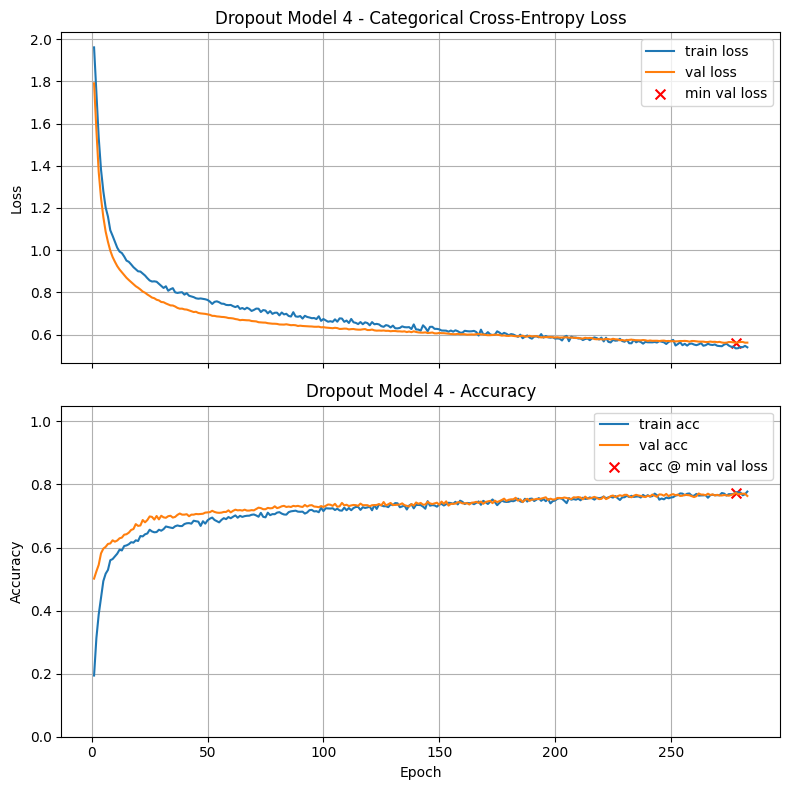

Final Training Loss:            0.5394
Final Training Accuracy:        0.7774
Final Validation Loss:          0.5616
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.5607 (Epoch 278)
Validation Accuracy @ Min Loss: 0.7736

Test Loss: 0.5837
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:01:48


In [42]:
dropout_model_4 = build_model(X_train.shape[1], [ (64, 'sigmoid', 0.0, 0.1), (32, 'sigmoid', 0.0, 0.3)], n_classes)
train_and_test(dropout_model_4, lr_schedule=1e-3, title="Dropout Model 4", return_history=False)


Dropout Model 5



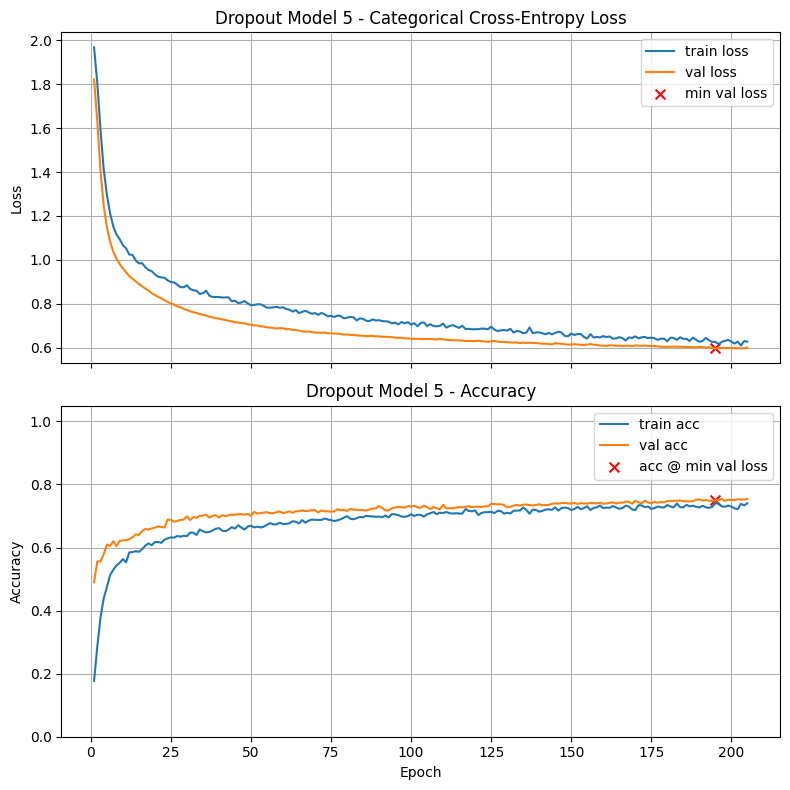

Final Training Loss:            0.6281
Final Training Accuracy:        0.7402
Final Validation Loss:          0.6016
Final Validation Accuracy:      0.7543
Minimum Validation Loss:        0.5974 (Epoch 195)
Validation Accuracy @ Min Loss: 0.7493

Test Loss: 0.6104
Test Accuracy: 0.7443

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:01:36


In [43]:
dropout_model_5 = build_model(X_train.shape[1], [ (64, 'sigmoid', 0.0, 0.1), (32, 'sigmoid', 0.0, 0.4)], n_classes)
train_and_test(dropout_model_5, lr_schedule=1e-3, title="Dropout Model 5", return_history=False)


Dropout Model 6



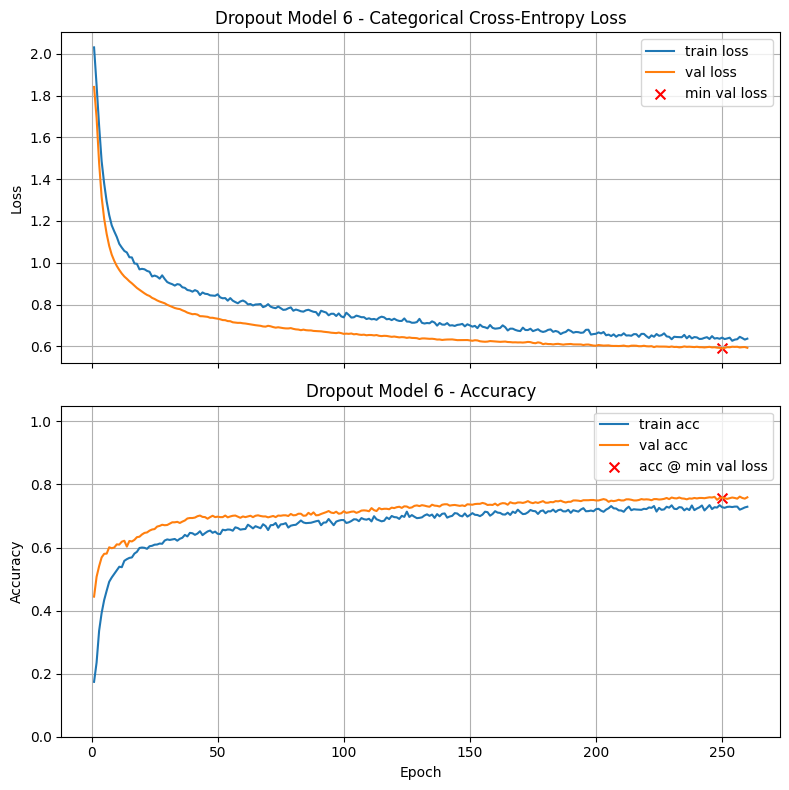

Final Training Loss:            0.6367
Final Training Accuracy:        0.7293
Final Validation Loss:          0.5930
Final Validation Accuracy:      0.7593
Minimum Validation Loss:        0.5902 (Epoch 250)
Validation Accuracy @ Min Loss: 0.7586

Test Loss: 0.6236
Test Accuracy: 0.7364

Validation-Test Gap (accuracy): 0.022143

Execution Time: 00:01:29


In [44]:
dropout_model_6 = build_model(X_train.shape[1], [ (64, 'sigmoid', 0.0, 0.1), (32, 'sigmoid', 0.0, 0.5)], n_classes)
train_and_test(dropout_model_6, lr_schedule=1e-3, title="Dropout Model 6", return_history=False)


Dropout Model 7



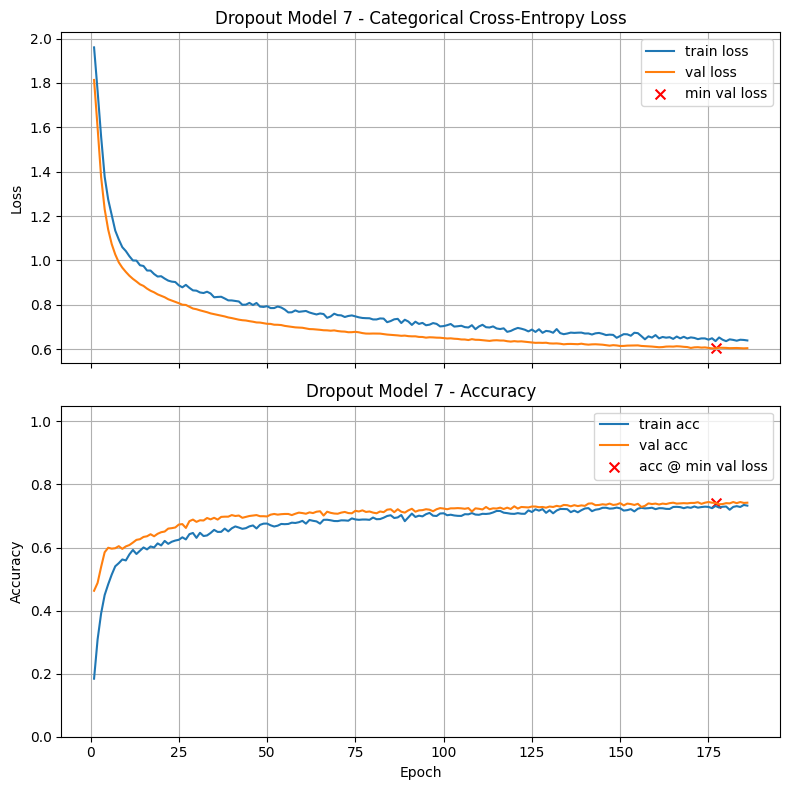

Final Training Loss:            0.6396
Final Training Accuracy:        0.7329
Final Validation Loss:          0.6048
Final Validation Accuracy:      0.7421
Minimum Validation Loss:        0.6039 (Epoch 177)
Validation Accuracy @ Min Loss: 0.7414

Test Loss: 0.6295
Test Accuracy: 0.7371

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:01:04


In [45]:
dropout_model_7 = build_model(X_train.shape[1], [ (64, 'sigmoid', 0.0, 0.2), (32, 'sigmoid', 0.0, 0.3)], n_classes)
train_and_test(dropout_model_7, lr_schedule=1e-3, title="Dropout Model 7", return_history=False)


Dropout Model 8



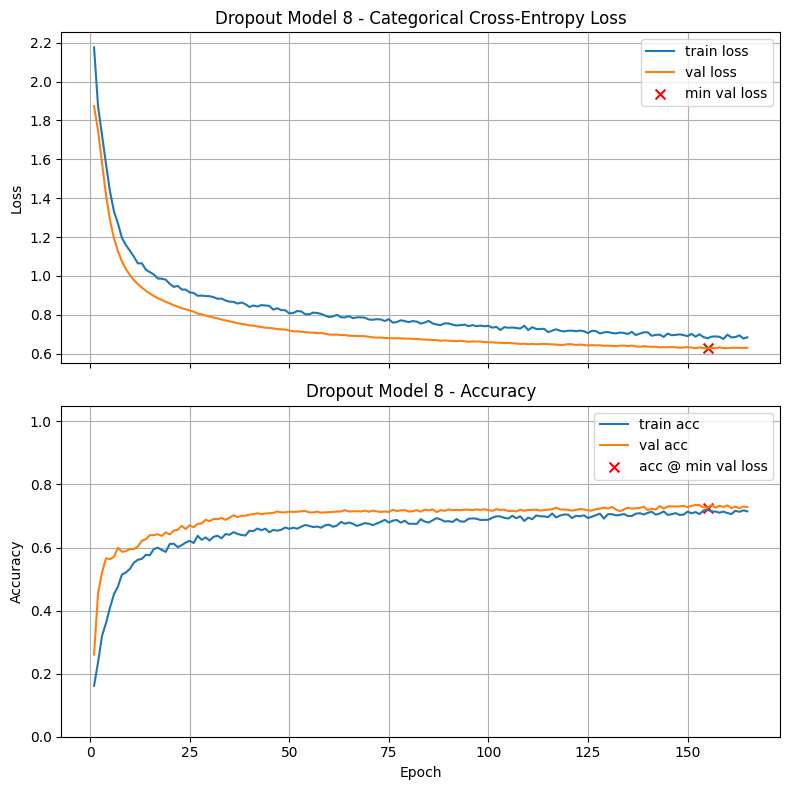

Final Training Loss:            0.6847
Final Training Accuracy:        0.7148
Final Validation Loss:          0.6306
Final Validation Accuracy:      0.7286
Minimum Validation Loss:        0.6277 (Epoch 155)
Validation Accuracy @ Min Loss: 0.7264

Test Loss: 0.6479
Test Accuracy: 0.7171

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:56


In [46]:
dropout_model_8 = build_model(X_train.shape[1], [ (64, 'sigmoid', 0.0, 0.2), (32, 'sigmoid', 0.0, 0.4)], n_classes)
train_and_test(dropout_model_8, lr_schedule=1e-3, title="Dropout Model 8", return_history=False)


Dropout Model 9



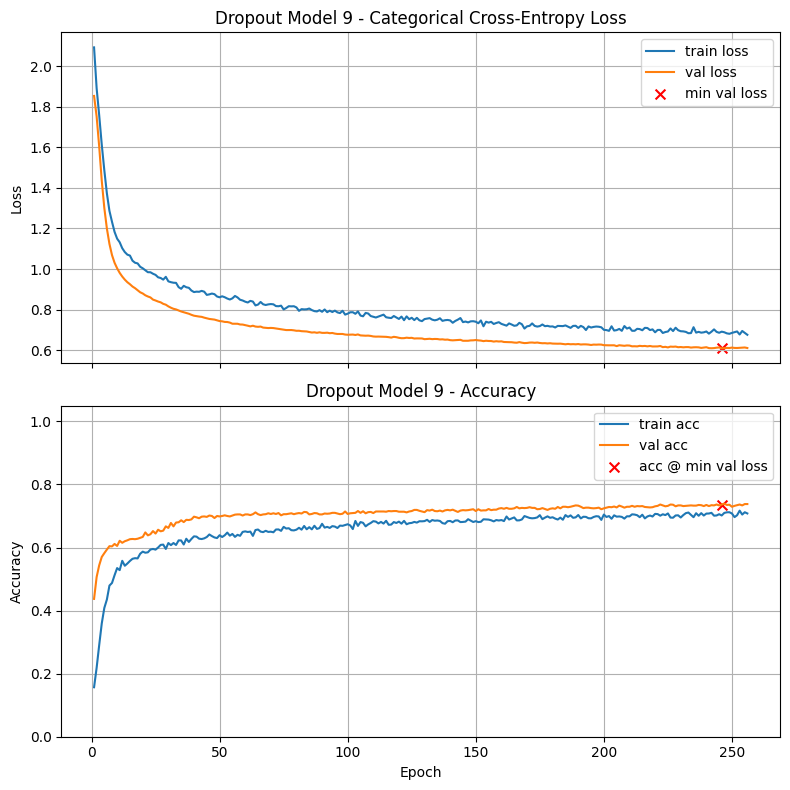

Final Training Loss:            0.6753
Final Training Accuracy:        0.7081
Final Validation Loss:          0.6101
Final Validation Accuracy:      0.7379
Minimum Validation Loss:        0.6082 (Epoch 246)
Validation Accuracy @ Min Loss: 0.7364

Test Loss: 0.6363
Test Accuracy: 0.7257

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:01:28


In [47]:
dropout_model_9 = build_model(X_train.shape[1], [ (64, 'sigmoid', 0.0, 0.2), (32, 'sigmoid', 0.0, 0.5)], n_classes)
train_and_test(dropout_model_9, lr_schedule=1e-3, title="Dropout Model 9", return_history=False)

In [48]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (0.1, 0.3)             # Replace (0.0,0.0) with your answer

In [49]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.1, 0.3)


In [50]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = 0.7736             # Replace 0.0 with your answer

In [51]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7736


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



L2 Regularization Model 1



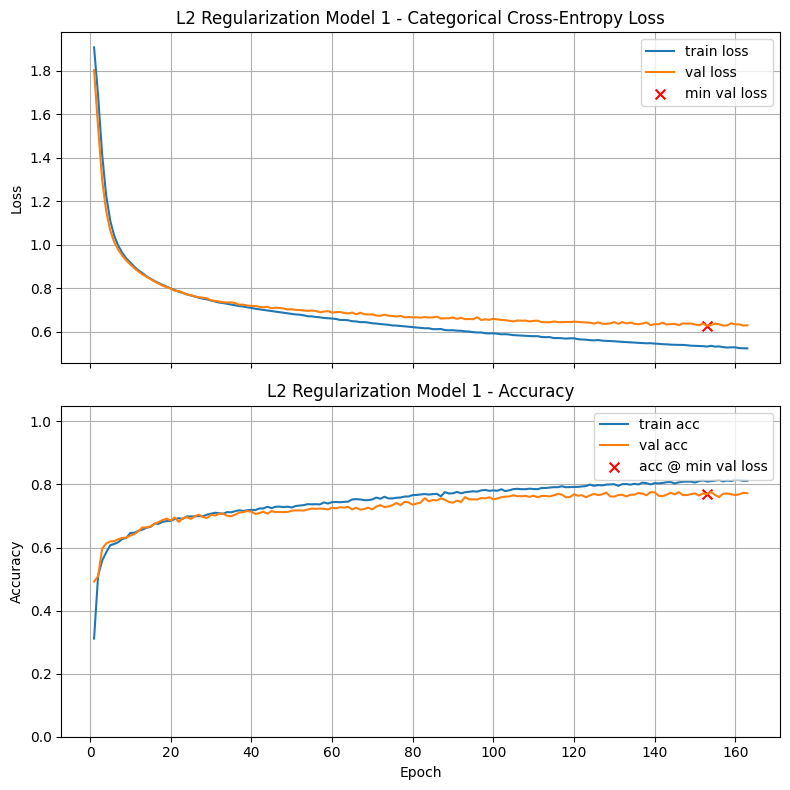

Final Training Loss:            0.5239
Final Training Accuracy:        0.8117
Final Validation Loss:          0.6301
Final Validation Accuracy:      0.7721
Minimum Validation Loss:        0.6282 (Epoch 153)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.6461
Test Accuracy: 0.7507

Validation-Test Gap (accuracy): 0.018571

Execution Time: 00:01:11


In [53]:
# Your code here. Add as many cells as you need. 
l2_model_1 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-4, 0.0), (32, 'sigmoid', 1e-4, 0.0)], n_classes)
train_and_test(l2_model_1, lr_schedule=1e-3, title="L2 Regularization Model 1", return_history=False)


L2 Regularization Model 2



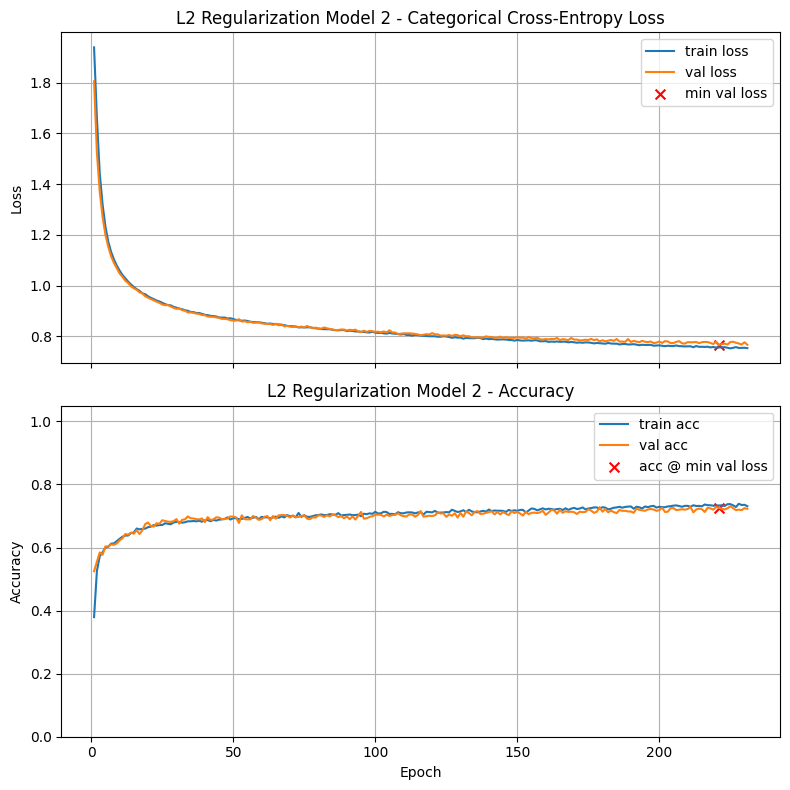

Final Training Loss:            0.7528
Final Training Accuracy:        0.7312
Final Validation Loss:          0.7662
Final Validation Accuracy:      0.7229
Minimum Validation Loss:        0.7653 (Epoch 221)
Validation Accuracy @ Min Loss: 0.7257

Test Loss: 0.7914
Test Accuracy: 0.7200

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:01:44


In [54]:
l2_model_2 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-3, 0.0), (32, 'sigmoid', 1e-3, 0.0)], n_classes)
train_and_test(l2_model_2, lr_schedule=1e-3, title="L2 Regularization Model 2", return_history=False)


L2 Regularization Model 3



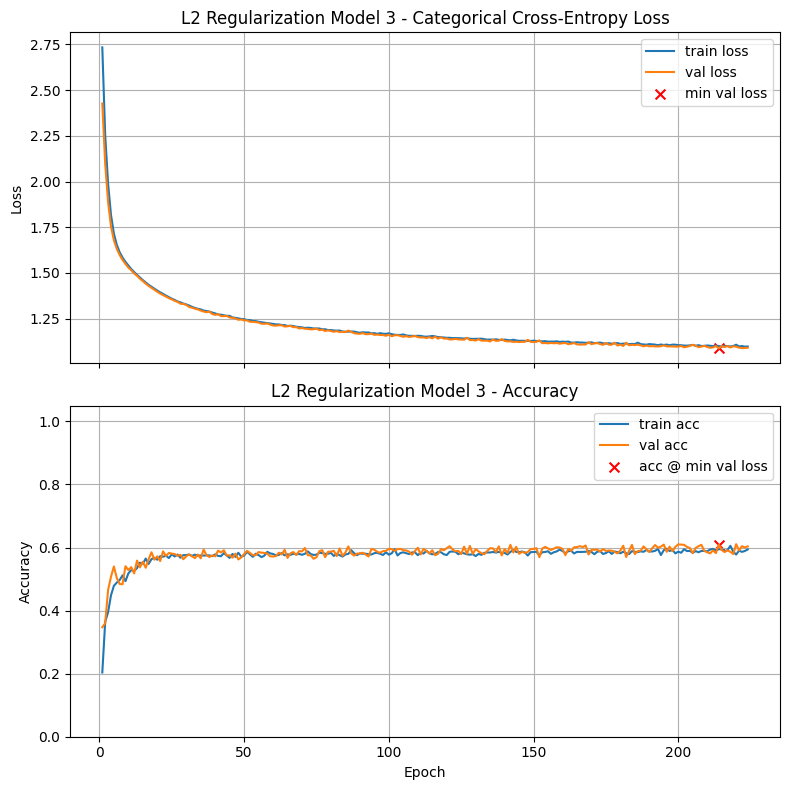

Final Training Loss:            1.0980
Final Training Accuracy:        0.5938
Final Validation Loss:          1.0911
Final Validation Accuracy:      0.6036
Minimum Validation Loss:        1.0877 (Epoch 214)
Validation Accuracy @ Min Loss: 0.6093

Test Loss: 1.1056
Test Accuracy: 0.5950

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:01:28


In [55]:
l2_model_3 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-2, 0.0), (32, 'sigmoid', 1e-2, 0.0)], n_classes)
train_and_test(l2_model_3, lr_schedule=1e-3, title="L2 Regularization Model 3", return_history=False)


L2 Regularization Model 4



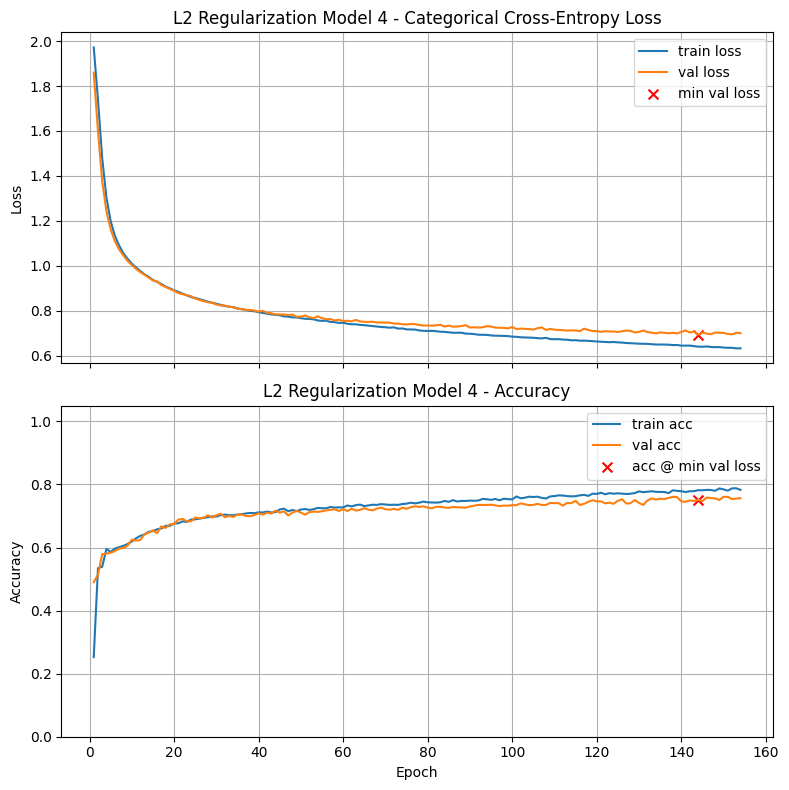

Final Training Loss:            0.6336
Final Training Accuracy:        0.7829
Final Validation Loss:          0.7009
Final Validation Accuracy:      0.7564
Minimum Validation Loss:        0.6945 (Epoch 144)
Validation Accuracy @ Min Loss: 0.7514

Test Loss: 0.7084
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:59


In [56]:
l2_model_4 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-4, 0.0), (32, 'sigmoid', 1e-3, 0.0)], n_classes)
train_and_test(l2_model_4, lr_schedule=1e-3, title="L2 Regularization Model 4", return_history=False)


L2 Regularization Model 5



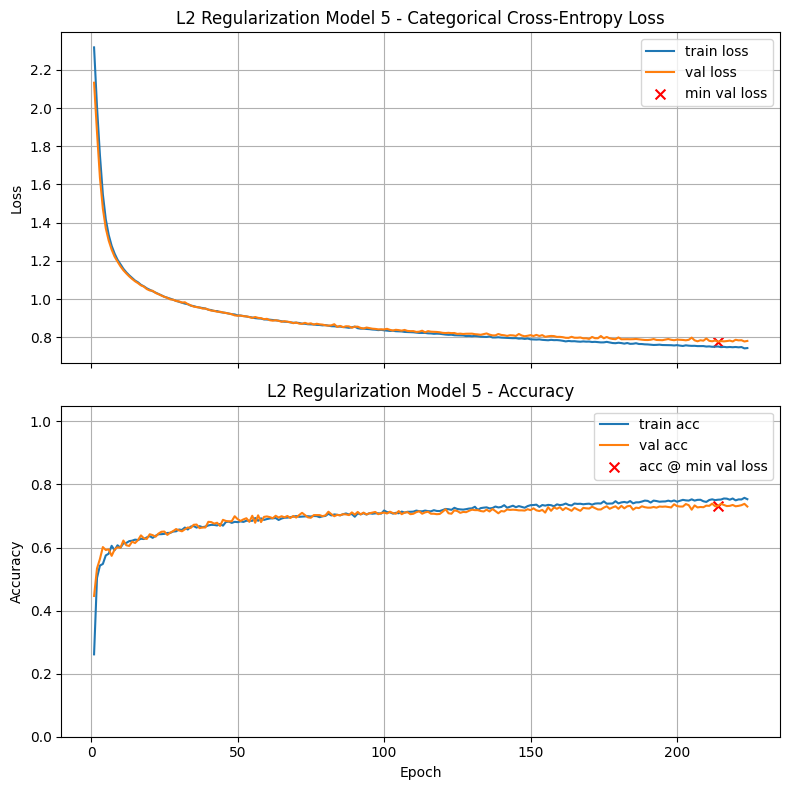

Final Training Loss:            0.7443
Final Training Accuracy:        0.7533
Final Validation Loss:          0.7816
Final Validation Accuracy:      0.7300
Minimum Validation Loss:        0.7778 (Epoch 214)
Validation Accuracy @ Min Loss: 0.7321

Test Loss: 0.8059
Test Accuracy: 0.7264

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:01:31


In [57]:
l2_model_5 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-4, 0.0), (32, 'sigmoid', 1e-2, 0.0)], n_classes)
train_and_test(l2_model_5, lr_schedule=1e-3, title="L2 Regularization Model 5", return_history=False)


L2 Regularization Model 6



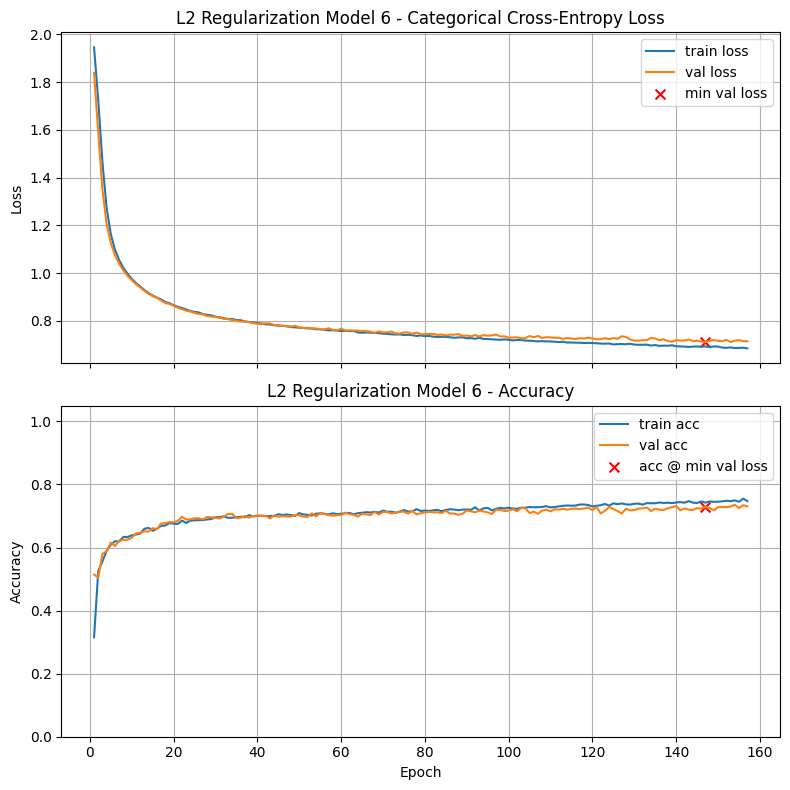

Final Training Loss:            0.6851
Final Training Accuracy:        0.7471
Final Validation Loss:          0.7146
Final Validation Accuracy:      0.7307
Minimum Validation Loss:        0.7107 (Epoch 147)
Validation Accuracy @ Min Loss: 0.7286

Test Loss: 0.7340
Test Accuracy: 0.7229

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:01:09


In [58]:
l2_model_6 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-3, 0.0), (32, 'sigmoid', 1e-4, 0.0)], n_classes)
train_and_test(l2_model_6, lr_schedule=1e-3, title="L2 Regularization Model 6", return_history=False)


L2 Regularization Model 7



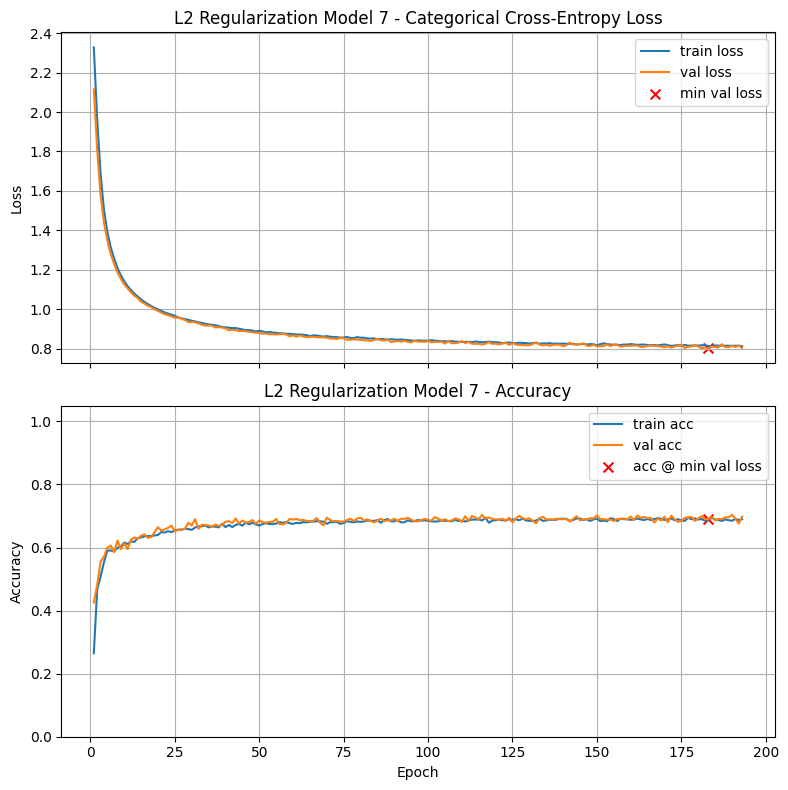

Final Training Loss:            0.8124
Final Training Accuracy:        0.6898
Final Validation Loss:          0.8031
Final Validation Accuracy:      0.6979
Minimum Validation Loss:        0.8012 (Epoch 183)
Validation Accuracy @ Min Loss: 0.6893

Test Loss: 0.8252
Test Accuracy: 0.6971

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:01:20


In [59]:
l2_model_7 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-2, 0.0), (32, 'sigmoid', 1e-4, 0.0)], n_classes)
train_and_test(l2_model_7, lr_schedule=1e-3, title="L2 Regularization Model 7", return_history=False)


L2 Regularization Model 8



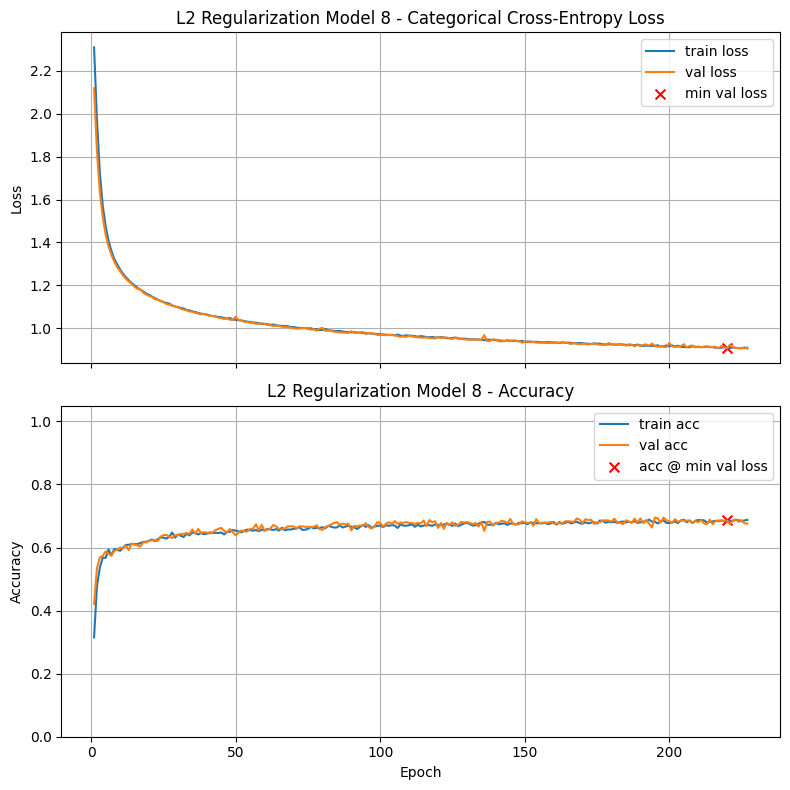

Final Training Loss:            0.9053
Final Training Accuracy:        0.6876
Final Validation Loss:          0.9089
Final Validation Accuracy:      0.6764
Minimum Validation Loss:        0.9056 (Epoch 220)
Validation Accuracy @ Min Loss: 0.6857

Test Loss: 0.9190
Test Accuracy: 0.6857

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:01:39


In [60]:
l2_model_8 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-3, 0.0), (32, 'sigmoid', 1e-2, 0.0)], n_classes)
train_and_test(l2_model_8, lr_schedule=1e-3, title="L2 Regularization Model 8", return_history=False)


L2 Regularization Model 9



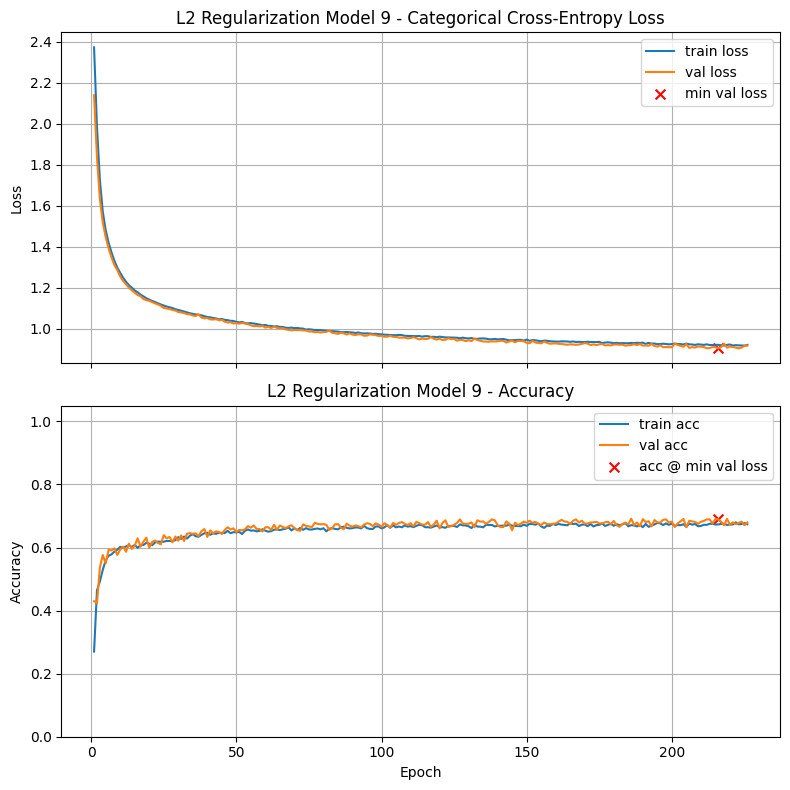

Final Training Loss:            0.9199
Final Training Accuracy:        0.6738
Final Validation Loss:          0.9167
Final Validation Accuracy:      0.6800
Minimum Validation Loss:        0.9032 (Epoch 216)
Validation Accuracy @ Min Loss: 0.6893

Test Loss: 0.9235
Test Accuracy: 0.6850

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:01:16


In [61]:
l2_model_9 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-2, 0.0), (32, 'sigmoid', 1e-3, 0.0)], n_classes)
train_and_test(l2_model_9, lr_schedule=1e-3, title="L2 Regularization Model 9", return_history=False)

In [62]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (1e-4, 1e-4)             # Replace (0.0,0.0) with your answer

In [63]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.0001, 0.0001)


In [64]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = 0.7693             # Replace 0.0 with your answer

In [65]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7693


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




Baseline Model with Dropout



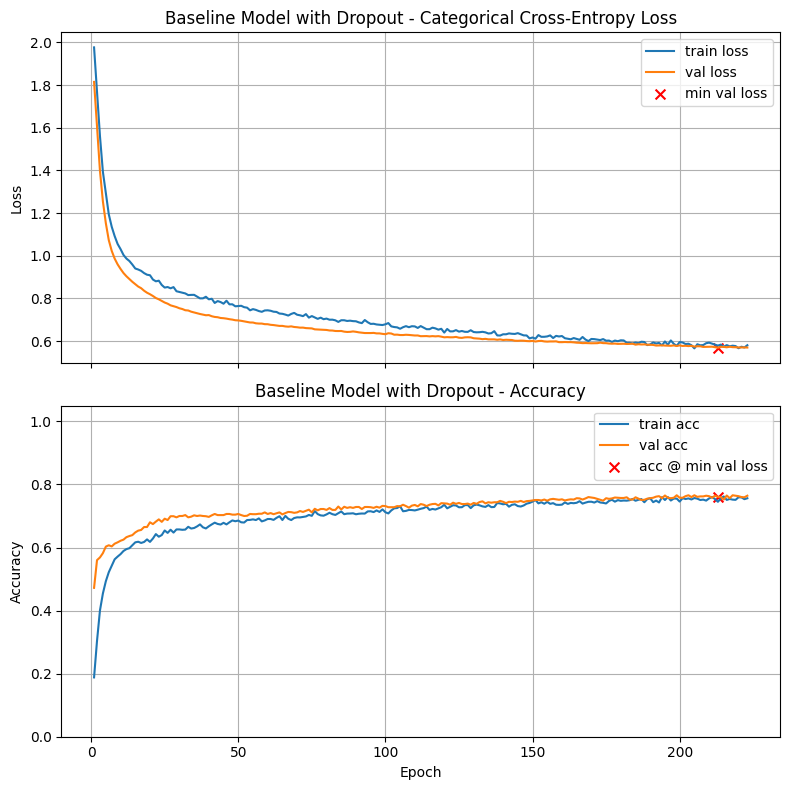

Final Training Loss:            0.5804
Final Training Accuracy:        0.7562
Final Validation Loss:          0.5696
Final Validation Accuracy:      0.7643
Minimum Validation Loss:        0.5687 (Epoch 213)
Validation Accuracy @ Min Loss: 0.7607

Test Loss: 0.6031
Test Accuracy: 0.7314

Validation-Test Gap (accuracy): 0.029286

Execution Time: 00:01:27


In [ ]:
# Your code here. Add as many cells as you need.

# baseline model with dropout only
baseline_model = build_model(X_train.shape[1], [ (64, 'sigmoid', 0.0, 0.1), (32, 'sigmoid', 0.0, 0.3)], n_classes)
train_and_test(baseline_model, lr_schedule=1e-3, title="Baseline Model with Dropout", return_history=False)


Dropout + Best L2 Regularization



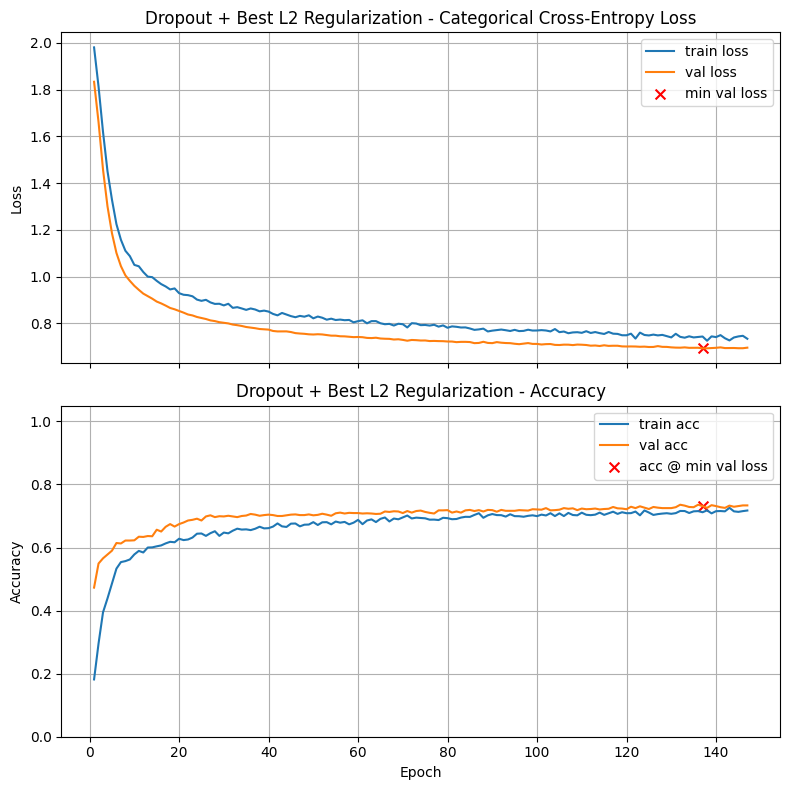

Final Training Loss:            0.7347
Final Training Accuracy:        0.7174
Final Validation Loss:          0.6966
Final Validation Accuracy:      0.7336
Minimum Validation Loss:        0.6936 (Epoch 137)
Validation Accuracy @ Min Loss: 0.7314

Test Loss: 0.7189
Test Accuracy: 0.7143

Validation-Test Gap (accuracy): 0.017143

Execution Time: 00:01:03


In [67]:
# drop out + best L2 regularization

model_2 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-4, 0.1), (32, 'sigmoid', 1e-4, 0.3)], n_classes)
train_and_test(model_2, lr_schedule=1e-3, title="Dropout + Best L2 Regularization", return_history=False)


Larger L2 + Dropout



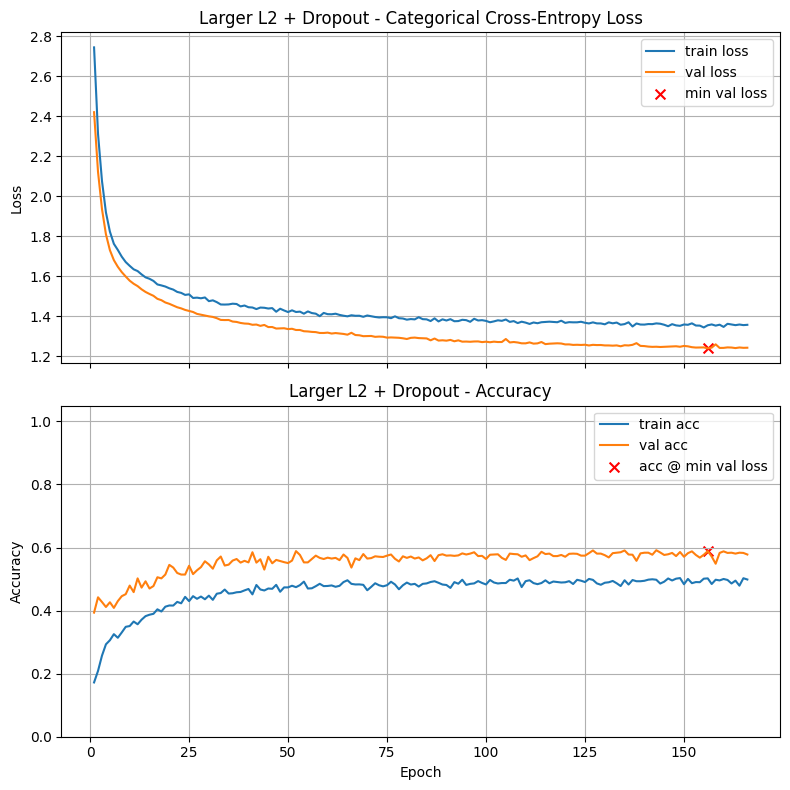

Final Training Loss:            1.3577
Final Training Accuracy:        0.4986
Final Validation Loss:          1.2433
Final Validation Accuracy:      0.5779
Minimum Validation Loss:        1.2401 (Epoch 156)
Validation Accuracy @ Min Loss: 0.5886

Test Loss: 1.2576
Test Accuracy: 0.5736

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:01:04


In [68]:
# making L2 larger because dropout is small

model_3 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-2, 0.1), (32, 'sigmoid', 1e-2, 0.3)], n_classes)
train_and_test(model_3, lr_schedule=1e-3, title="Larger L2 + Dropout", return_history=False)


Mixing up L2 + Dropout



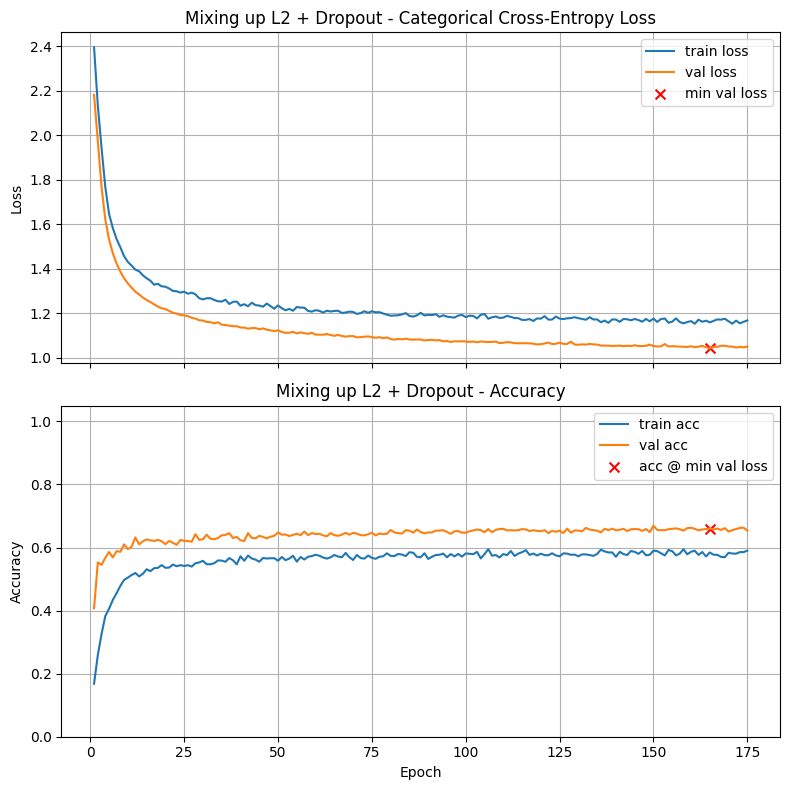

Final Training Loss:            1.1670
Final Training Accuracy:        0.5902
Final Validation Loss:          1.0492
Final Validation Accuracy:      0.6536
Minimum Validation Loss:        1.0410 (Epoch 165)
Validation Accuracy @ Min Loss: 0.6600

Test Loss: 1.0696
Test Accuracy: 0.6500

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:59


In [69]:
# mixing up l2 

model_4 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-3, 0.1), (32, 'sigmoid', 1e-2, 0.3)], n_classes)
train_and_test(model_4, lr_schedule=1e-3, title="Mixing up L2 + Dropout", return_history=False)


L2 + Dropout



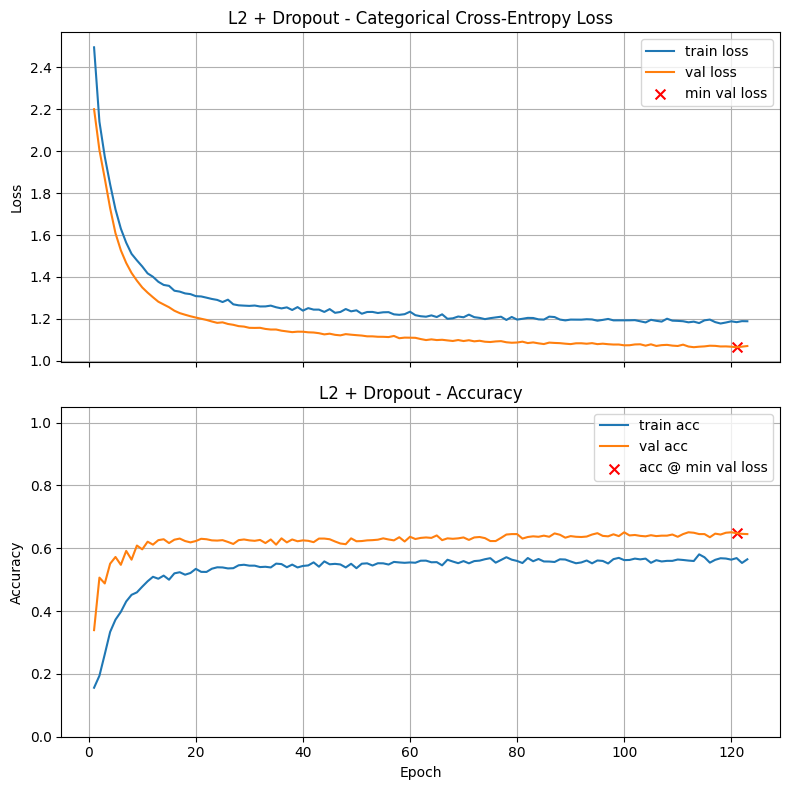

Final Training Loss:            1.1887
Final Training Accuracy:        0.5648
Final Validation Loss:          1.0705
Final Validation Accuracy:      0.6450
Minimum Validation Loss:        1.0648 (Epoch 121)
Validation Accuracy @ Min Loss: 0.6479

Test Loss: 1.0911
Test Accuracy: 0.6393

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:38


In [70]:
model_5 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-2, 0.1), (32, 'sigmoid', 1e-3, 0.3)], n_classes)
train_and_test(model_5, lr_schedule=1e-3, title="L2 + Dropout", return_history=False)


L2 + Dropout



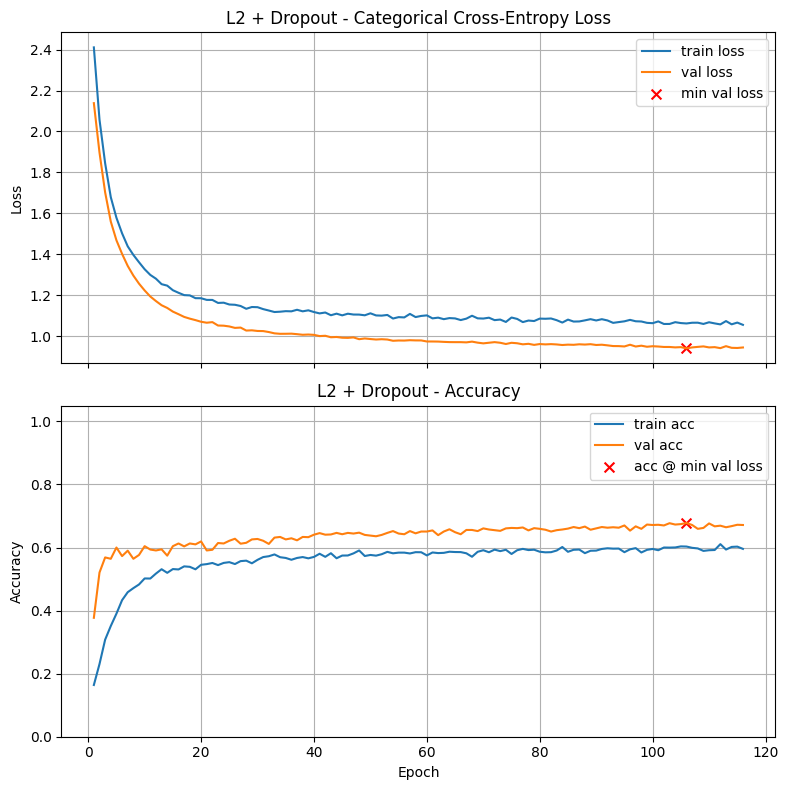

Final Training Loss:            1.0548
Final Training Accuracy:        0.5957
Final Validation Loss:          0.9442
Final Validation Accuracy:      0.6714
Minimum Validation Loss:        0.9398 (Epoch 106)
Validation Accuracy @ Min Loss: 0.6779

Test Loss: 0.9642
Test Accuracy: 0.6607

Validation-Test Gap (accuracy): 0.017143

Execution Time: 00:00:35


In [71]:
model_6 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-2, 0.1), (32, 'sigmoid', 1e-4, 0.3)], n_classes)
train_and_test(model_6, lr_schedule=1e-3, title="L2 + Dropout", return_history=False)


L2 + Dropout



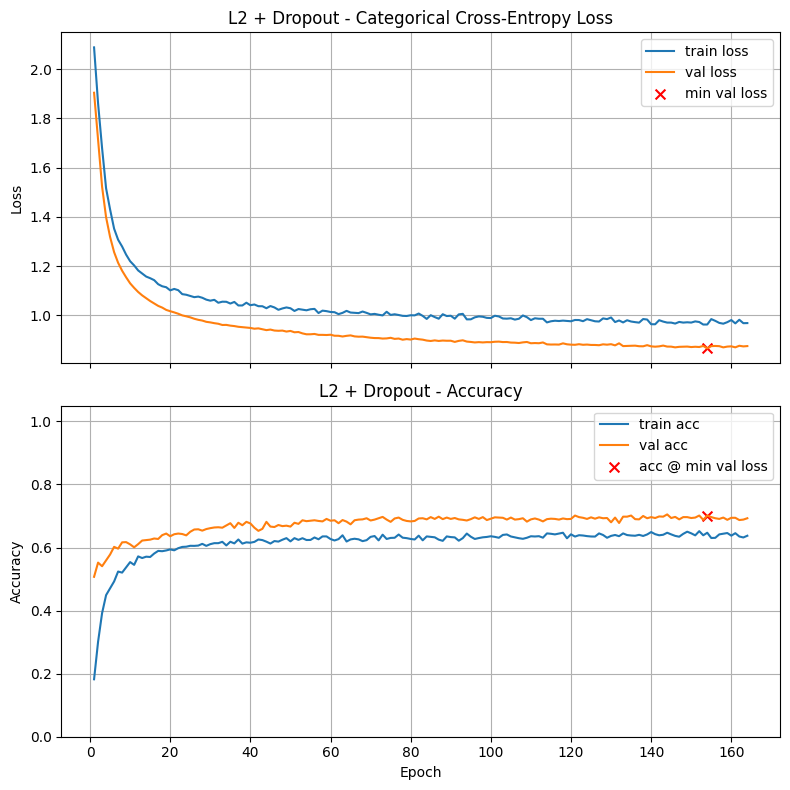

Final Training Loss:            0.9680
Final Training Accuracy:        0.6374
Final Validation Loss:          0.8745
Final Validation Accuracy:      0.6929
Minimum Validation Loss:        0.8651 (Epoch 154)
Validation Accuracy @ Min Loss: 0.7014

Test Loss: 0.8862
Test Accuracy: 0.6864

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:00:58


In [72]:
model_7 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-3, 0.1), (32, 'sigmoid', 1e-3, 0.3)], n_classes)
train_and_test(model_7, lr_schedule=1e-3, title="L2 + Dropout", return_history=False)


L2 + Dropout



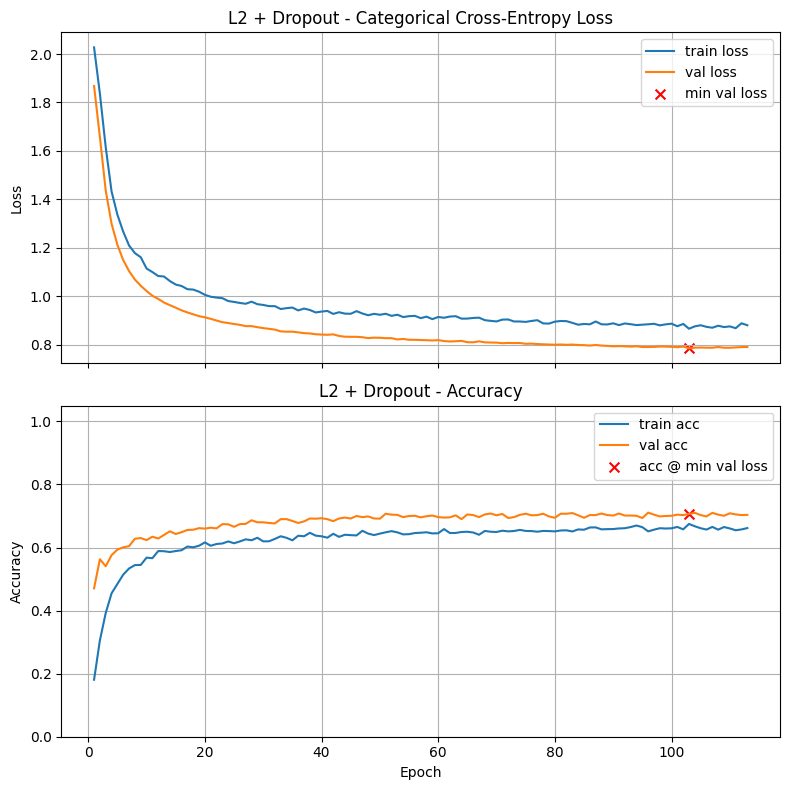

Final Training Loss:            0.8804
Final Training Accuracy:        0.6617
Final Validation Loss:          0.7907
Final Validation Accuracy:      0.7036
Minimum Validation Loss:        0.7849 (Epoch 103)
Validation Accuracy @ Min Loss: 0.7064

Test Loss: 0.8034
Test Accuracy: 0.7021

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:00:40


In [73]:
model_8 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-3, 0.1), (32, 'sigmoid', 1e-4, 0.3)], n_classes)
train_and_test(model_8, lr_schedule=1e-3, title="L2 + Dropout", return_history=False)


L2 + Dropout



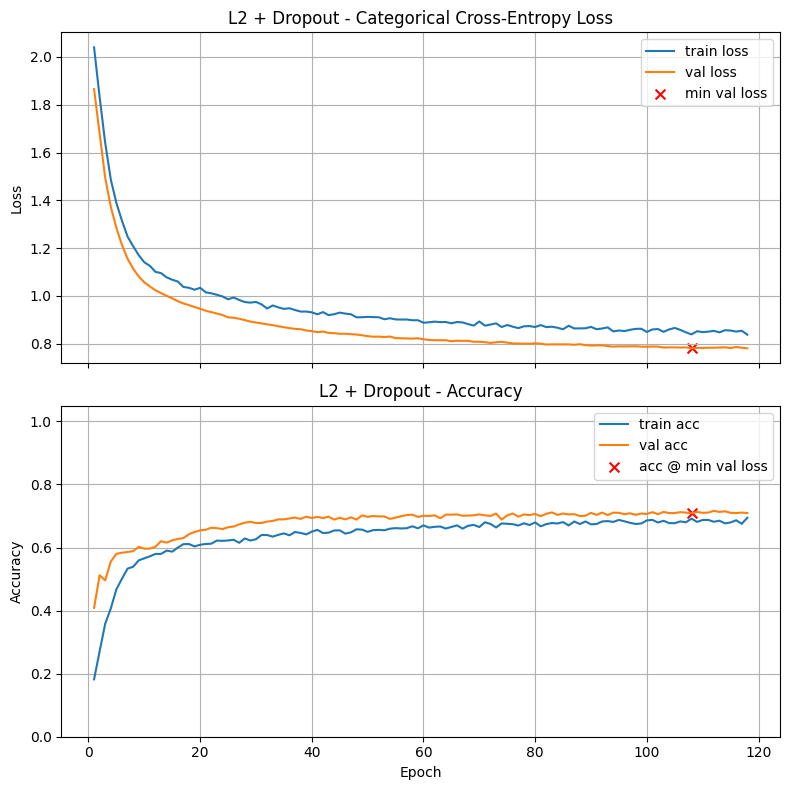

Final Training Loss:            0.8374
Final Training Accuracy:        0.6943
Final Validation Loss:          0.7803
Final Validation Accuracy:      0.7093
Minimum Validation Loss:        0.7801 (Epoch 108)
Validation Accuracy @ Min Loss: 0.7086

Test Loss: 0.8045
Test Accuracy: 0.6964

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:43


In [74]:
model_9 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-4, 0.1), (32, 'sigmoid', 1e-3, 0.3)], n_classes)
train_and_test(model_9, lr_schedule=1e-3, title="L2 + Dropout", return_history=False)


L2 + Dropout



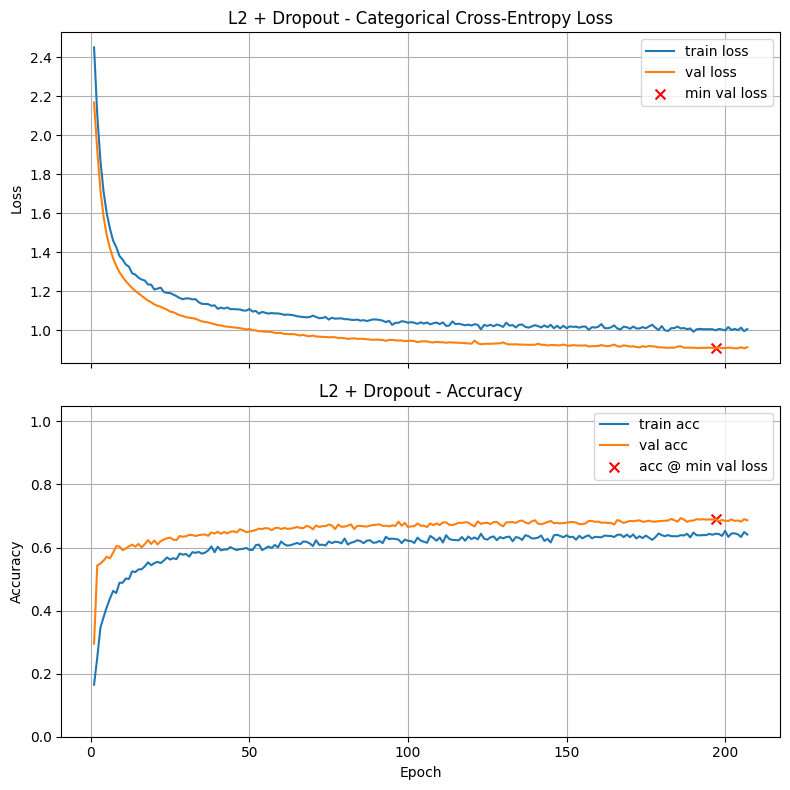

Final Training Loss:            1.0062
Final Training Accuracy:        0.6412
Final Validation Loss:          0.9128
Final Validation Accuracy:      0.6864
Minimum Validation Loss:        0.9071 (Epoch 197)
Validation Accuracy @ Min Loss: 0.6900

Test Loss: 0.9319
Test Accuracy: 0.6800

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:01:14


In [75]:
model_10 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-4, 0.1), (32, 'sigmoid', 1e-2, 0.3)], n_classes)
train_and_test(model_10, lr_schedule=1e-3, title="L2 + Dropout", return_history=False)


L2 + Dropout



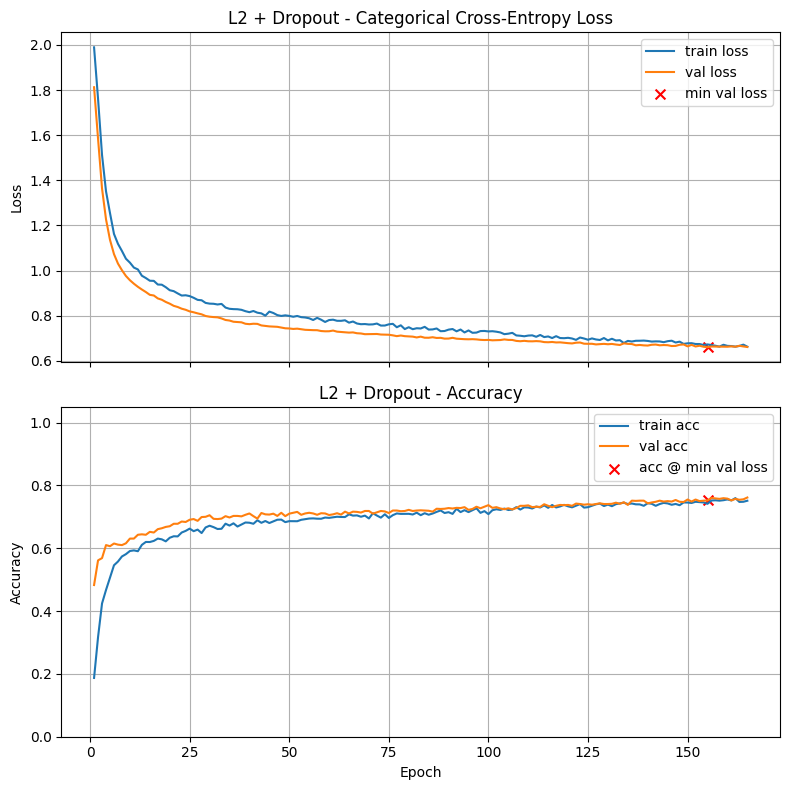

Final Training Loss:            0.6627
Final Training Accuracy:        0.7512
Final Validation Loss:          0.6613
Final Validation Accuracy:      0.7614
Minimum Validation Loss:        0.6604 (Epoch 155)
Validation Accuracy @ Min Loss: 0.7521

Test Loss: 0.6890
Test Accuracy: 0.7429

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:52


In [76]:
model_11 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-4, 0.0), (32, 'sigmoid', 1e-4, 0.3)], n_classes)
train_and_test(model_11, lr_schedule=1e-3, title="L2 + Dropout", return_history=False)


L2 + Dropout



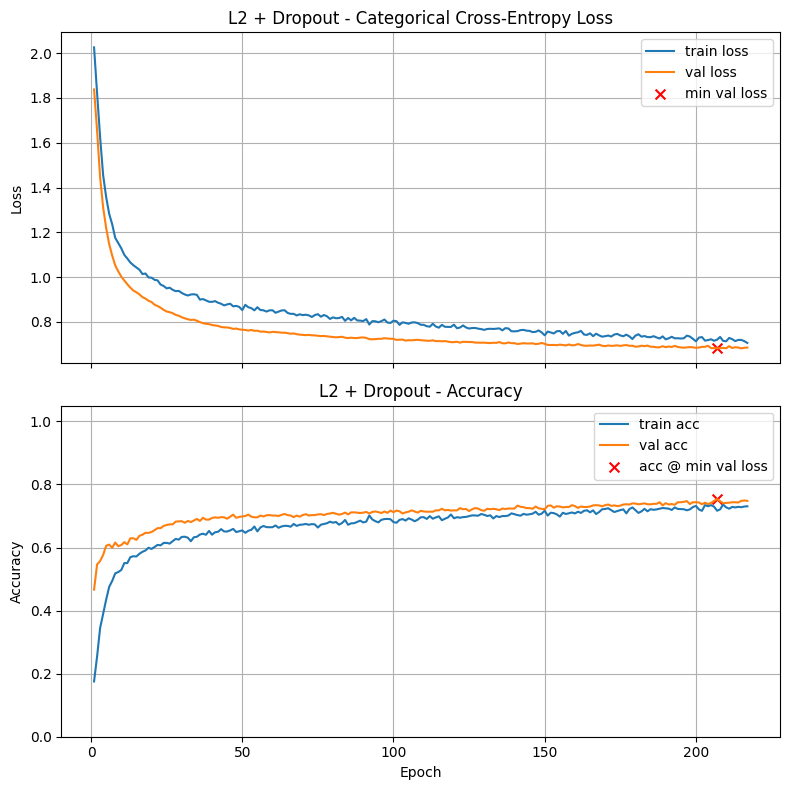

Final Training Loss:            0.7065
Final Training Accuracy:        0.7307
Final Validation Loss:          0.6857
Final Validation Accuracy:      0.7479
Minimum Validation Loss:        0.6822 (Epoch 207)
Validation Accuracy @ Min Loss: 0.7536

Test Loss: 0.6983
Test Accuracy: 0.7421

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:02:06


In [81]:
model_12 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-4, 0.0), (32, 'sigmoid', 1e-4, 0.5)], n_classes)
train_and_test(model_12, lr_schedule=1e-3, title="L2 + Dropout", return_history=False)


L2 + Dropout



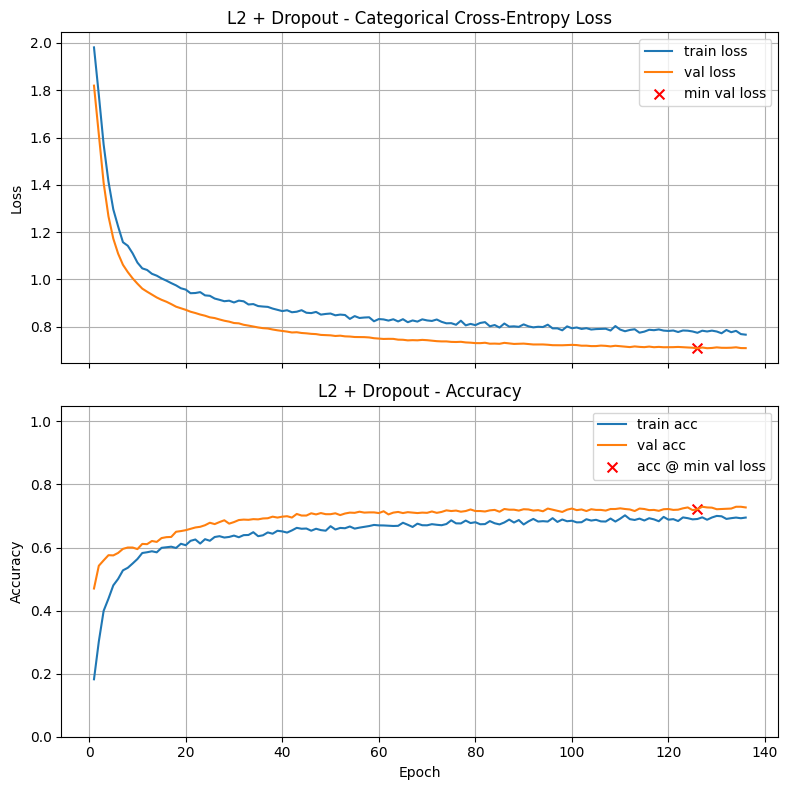

Final Training Loss:            0.7667
Final Training Accuracy:        0.6950
Final Validation Loss:          0.7098
Final Validation Accuracy:      0.7271
Minimum Validation Loss:        0.7087 (Epoch 126)
Validation Accuracy @ Min Loss: 0.7214

Test Loss: 0.7306
Test Accuracy: 0.7136

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:01:42


In [85]:
model_13 = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-4, 0.2), (32, 'sigmoid', 1e-4, 0.3)], n_classes)
train_and_test(model_13, lr_schedule=1e-3, title="L2 + Dropout", return_history=False)

In [86]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = 0.7536             # Replace 0.0 with your answer

In [87]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.7536


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.



Best Model



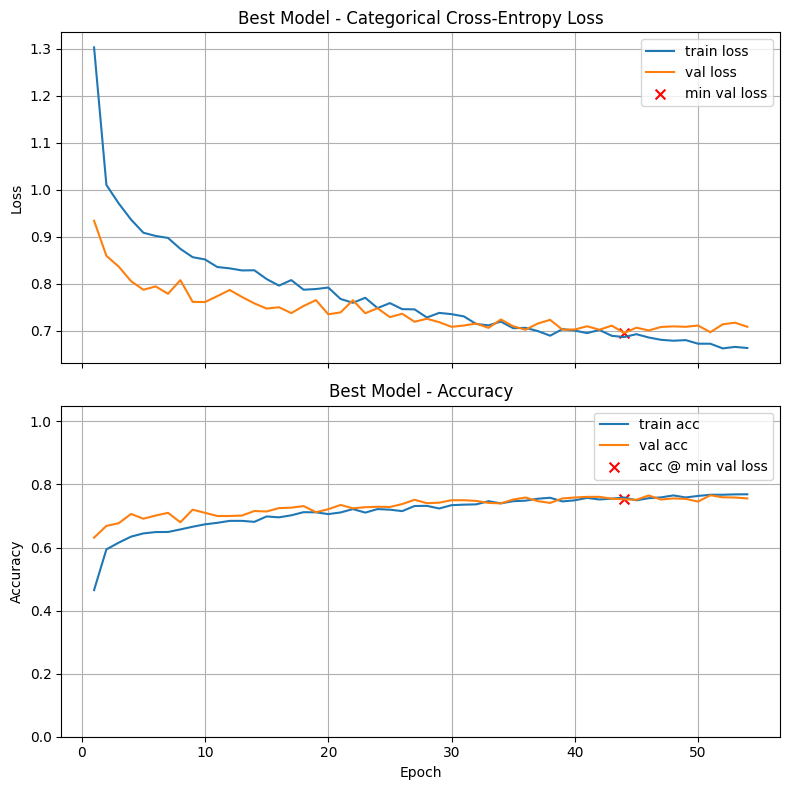

Final Training Loss:            0.6632
Final Training Accuracy:        0.7688
Final Validation Loss:          0.7084
Final Validation Accuracy:      0.7557
Minimum Validation Loss:        0.6953 (Epoch 44)
Validation Accuracy @ Min Loss: 0.7529

Test Loss: 0.7257
Test Accuracy: 0.7429

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:38


In [117]:
# Your code here

initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_lr,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)

best_model = build_model(X_train.shape[1], [ (64, 'sigmoid', 1e-4, 0.0), (32, 'sigmoid', 1e-4, 0.5)], n_classes)
train_and_test(best_model, lr_schedule=lr_schedule, batch_size=16, title="Best Model", return_history=False)

In [118]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.7529             # Replace 0.0 with your answer

In [119]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.7529


### Optional: Print out your results of all experiments

In [120]:
print_results()

Baseline Model - LR=5e-05               	0.7836
Baseline Model - LR=1e-05               	0.7821
Baseline Model - LR=0.0001              	0.7807
Baseline Model - LR=0.0005              	0.7779
Baseline Model - Sigmoid Activation     	0.7757
Baseline Model - LR=0.001               	0.7736
Dropout Model 4                         	0.7736
Baseline Model - Tanh Activation        	0.7729
Baseline Model - LR=1e-3                	0.7729
Dropout Model 1                         	0.7714
Baseline Model - LR=5e-4                	0.7700
L2 Regularization Model 1               	0.7693
Dropout Model 2                         	0.7629
Baseline Model with Dropout             	0.7607
Baseline Model - ReLU Activation        	0.7593
Dropout Model 6                         	0.7586
Best Model                              	0.7529
L2 Regularization Model 4               	0.7514
Dropout Model 3                         	0.7493
Dropout Model 5                         	0.7493
Dropout Model 7                         

## Reflection Questions (ungraded)

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?